'''
# Hybrid Trading Strategy (ATR Regime → EMA vs Bollinger)

## Strategy Explanation

This strategy combines two classic approaches to trading:
1. **Trend-Following (EMA Crossover)**
2. **Mean Reversion (Bollinger Bands)**

Instead of using only one approach, the system adapts based on the **market regime**:
- **Trending / High Volatility Market:**
    - Detected using **ATR (Average True Range) / Price ratio**.
    - If ATR/Close is above a threshold → Market is volatile and directional.
    - In this regime, we apply a **trend-following strategy** using an EMA crossover.
        - Buy when the short-term EMA crosses above the long-term EMA.
        - Sell when the short-term EMA crosses below the long-term EMA.

- **Calm / Range-Bound Market:**
    - If ATR/Close is below the threshold → Market is stable and sideways.
    - In this regime, we apply a **mean reversion strategy** using Bollinger Bands.
        - Buy when price moves below the lower Bollinger Band (oversold).
        - Sell when price moves above the upper Bollinger Band (overbought).
        - Exit positions when price reverts to the middle band (SMA).


## Goal
This hybrid approach allows the strategy to adapt dynamically:
- Capture large moves when the market is trending.
- Take advantage of reversions when the market is quiet.
- Avoid applying the wrong strategy in the wrong market regime.
'''


In [370]:
# We will start off by importing the necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [371]:
# We will operate with a variable trading strategy on the S&P 500
ticker = 'SPY'
spy_data = yf.download(ticker, start="2024-01-01", end="2025-09-01")


/tmp/ipython-input-2169392648.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download(ticker, start="2024-01-01", end="2025-09-01")
[*********************100%***********************]  1 of 1 completed


In [372]:
# We want to see how this data is arranged
spy_data.head(n=1)

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2024-01-02,462.610382,463.608735,460.496259,462.1308,123623700


In [373]:
# The TR value is defined as the max out of three different values, we will calculate each into a numpy array
tr_m1 = spy_data['High']-spy_data['Low'] # Its the TR measurement 1
tr_m2 = (spy_data['High']-spy_data['Close'].shift()).abs()
tr_m3 = (spy_data['Close'].shift()-spy_data['Low']).abs()
tr = pd.concat([tr_m1, tr_m2, tr_m3], axis=1).max(axis=1) # We now know the True Range During this period, we will use this for the ATR

In [374]:
# We define the rolling period of ATR to be 14 days
atr_period = 14
atr = tr.rolling(window=atr_period).mean()
spy_data['atr']=atr.dropna()
# With this, we already set up the definition of our regime.

In [375]:
# We will now calculate the exponential moving averages
ema_short_window = 5 # We define the short window
ema_long_window = 10 # We define the long window
spy_data['ema_short'] = spy_data['Close'].ewm(span=ema_short_window, adjust=False).mean() # We create the short term EMA
spy_data['ema_long'] = spy_data['Close'].ewm(span=ema_long_window, adjust=False).mean() # We create the long term Ema
# We will later use these for EMA Crossover

In [376]:
# We will now calculate the Bollinger Bands

bands_period = 20
spy_data['sma'] = spy_data['Close'][ticker].rolling(window=bands_period).mean()
spy_data['bands_upper'] = spy_data['sma'] + 2 * spy_data['Close'][ticker].rolling(window=bands_period).std()
spy_data['bands_lower'] = spy_data['sma'] - 2 * spy_data['Close'][ticker].rolling(window=bands_period).std()


In [377]:
# We will now do regime definition
regime_indicator = 0.012
close = spy_data.loc[atr.index, 'Close'] # Because it takes time for the atr to be calculated, we must give offset the close
close = close[ticker] # Close is a dataframe, we must make it a series
atr_ratio = atr/close # We now divide each series
atr_ratio=atr_ratio.dropna()
regime = atr_ratio>regime_indicator # We now have a true or false series based on regime

In [378]:
# === Signal Generation ===

# Assign regime (True = volatile/trending, False = calm/range-bound)
spy_data['Regime'] = regime.astype(bool)

# EMA Crossover Signals
spy_data['EMA_Buy'] = ((spy_data['ema_short'] > spy_data['ema_long']) & (spy_data['ema_short'].shift(1) <= spy_data['ema_long'].shift(1)))
spy_data['EMA_Sell'] = ((spy_data['ema_short'] < spy_data['ema_long']) & (spy_data['ema_short'].shift(1) >= spy_data['ema_long'].shift(1)))

# Bollinger Bands Signals
spy_data['BB_Buy'] = spy_data['Close'][ticker] < spy_data['bands_lower']
spy_data['BB_Sell'] = spy_data['Close'][ticker] > spy_data['bands_upper']
spy_data['BB_Exit'] = ((spy_data['Close'][ticker] >= spy_data['sma']) & (spy_data['Close'][ticker] <= spy_data['bands_upper']) & (spy_data['Close'][ticker] >= spy_data['bands_lower']))

# Final Buy/Sell signals depending on regime
spy_data['Buy_Signal'] = spy_data['Regime'] & spy_data['EMA_Buy']
spy_data['Sell_Signal'] = spy_data['Regime'] & spy_data['EMA_Sell']
spy_data.loc[spy_data['Regime'] == False, 'Buy_Signal'] = spy_data['BB_Buy']
spy_data.loc[spy_data['Regime'] == False, 'Sell_Signal'] = spy_data['BB_Sell']
spy_data['Exit_Signal'] = (spy_data['Regime'] == False) & spy_data['BB_Exit']

In [379]:
# Position Management
spy_data['Position'] = 0
position_col_idx = spy_data.columns.get_loc('Position')

for i in range(1, len(spy_data)):
    prev_pos = spy_data.iloc[i-1, position_col_idx]
    buy_signal = bool(spy_data['Buy_Signal'].iloc[i])
    sell_signal = bool(spy_data['Sell_Signal'].iloc[i])
    exit_signal = bool(spy_data['Exit_Signal'].iloc[i])

    current_pos = prev_pos
    if buy_signal:
        current_pos = 1
    if sell_signal or exit_signal:
        current_pos = 0

    spy_data.iloc[i, position_col_idx] = current_pos

# Strategy Returns
spy_data['Market_Return'] = spy_data['Close'][ticker].pct_change()
spy_data['Strategy_Return'] = spy_data['Market_Return'] * spy_data['Position'].shift(1)

# Performance Metrics
cumulative_return = (1 + spy_data['Strategy_Return'].fillna(0)).cumprod()
buy_hold_return = (1 + spy_data['Market_Return'].fillna(0)).cumprod()

total_return = cumulative_return.iloc[-1] - 1
annualized_return = (1 + total_return) ** (252 / len(spy_data)) - 1
annualized_volatility = spy_data['Strategy_Return'].std() * (252 ** 0.5)
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Return: 20.66%
Annualized Return: 12.02%
Annualized Volatility: 8.55%
Sharpe Ratio: 1.41


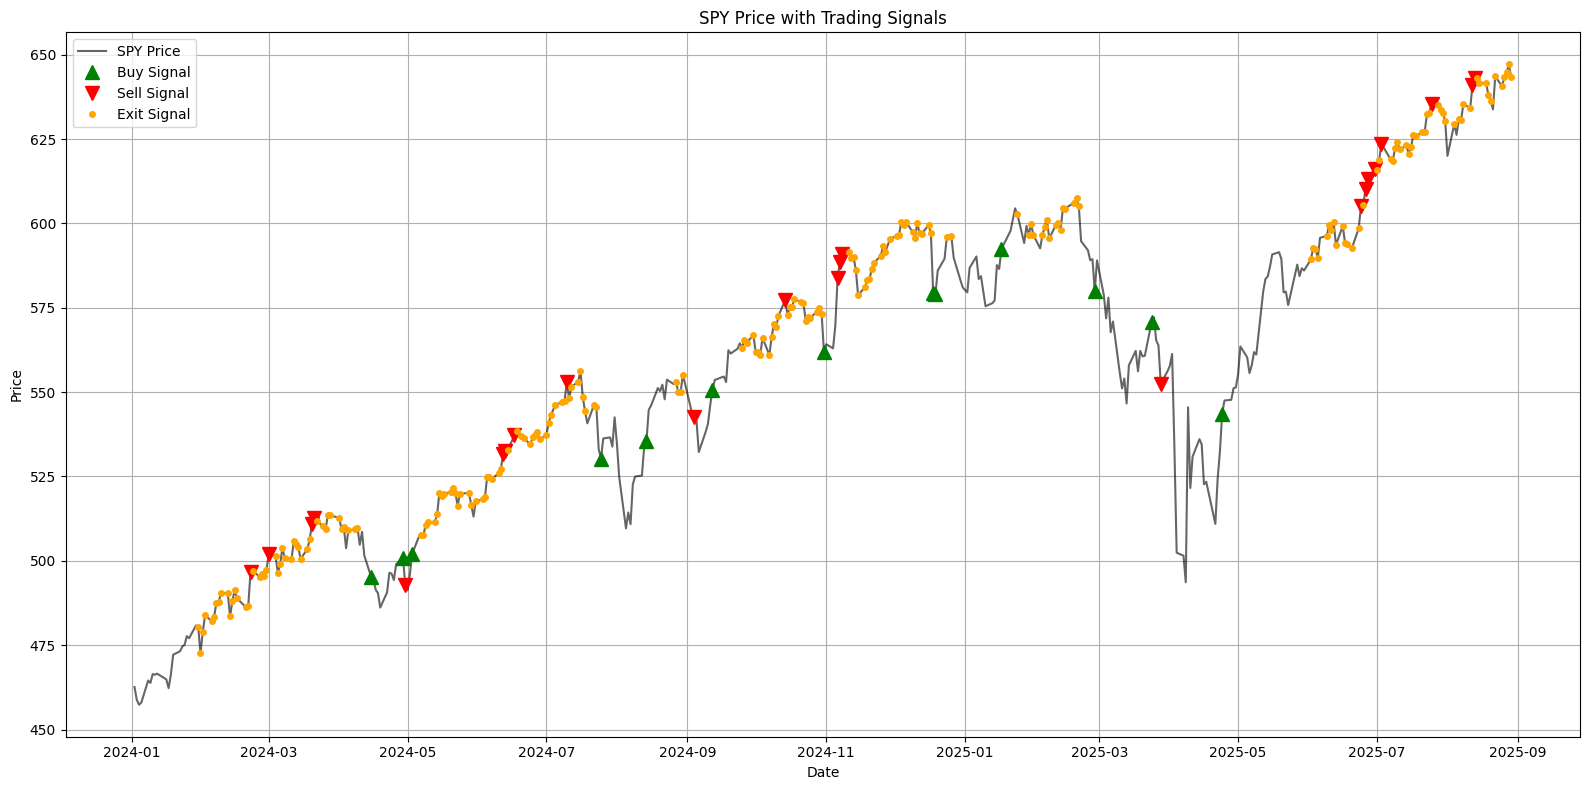

In [380]:

# Plotting
plt.figure(figsize=(16, 8))

# Plot Close Price
plt.plot(spy_data['Close'][ticker], label=f'{ticker} Price', color='black', alpha=0.6)

# Plot Buy Signals
plt.plot(spy_data.loc[spy_data['Buy_Signal']].index,
         spy_data['Close'][ticker][spy_data['Buy_Signal']],
         '^', markersize=10, color='green', label='Buy Signal')

# Plot Sell Signals
plt.plot(spy_data.loc[spy_data['Sell_Signal']].index,
         spy_data['Close'][ticker][spy_data['Sell_Signal']],
         'v', markersize=10, color='red', label='Sell Signal')

# Plot Exit Signals
plt.plot(spy_data.loc[spy_data['Exit_Signal']].index,
         spy_data['Close'][ticker][spy_data['Exit_Signal']],
         'o', markersize=4, color='orange', label='Exit Signal')

plt.title(f"{ticker} Price with Trading Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

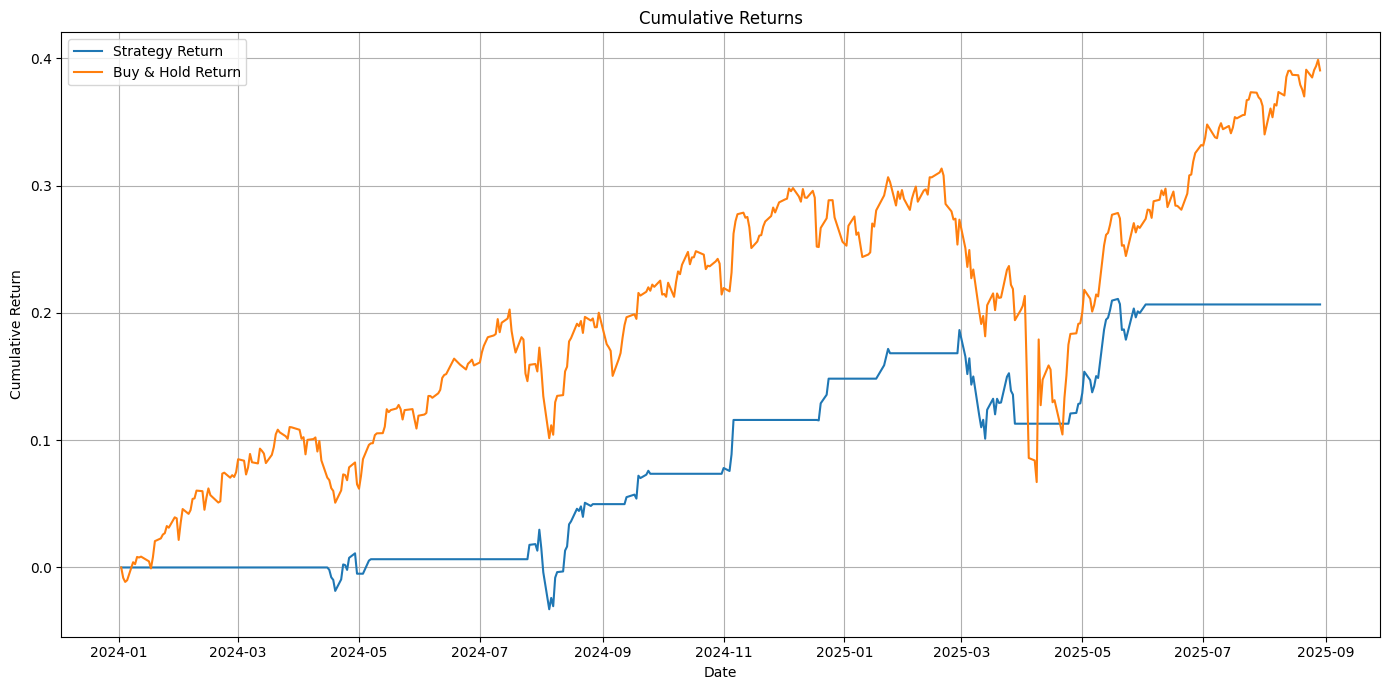

In [381]:
plt.figure(figsize=(14,7))
plt.plot((1 + spy_data['Strategy_Return'].fillna(0)).cumprod() - 1, label='Strategy Return')
plt.plot((1 + spy_data['Market_Return'].fillna(0)).cumprod() - 1, label='Buy & Hold Return')
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
